# 测试不同的流场的获取方式，flow.py的代码结构
- FlowField: 负责加载、延拓、插值 数据集流场。

- AnalyticalFlow: 管理多个 解析流场函数（如 uniform、solid_rot 等）。

- FlowManager: 提供统一接口 evaluate(x_, y_)，支持无缝切换使用哪一种流场。

In [1]:
# # flow.py
# import numpy as np
# import cv2
# from scipy.integrate import cumtrapz


# class FlowField:
#     def __init__(self, data_path="./data/backstep_Re1000_00004.npz", num_iter=500, tol=1e-4):
#         self.img1, self.img2, self.u, self.v = self._read_data(data_path)
#         self.u_ext, self.v_ext, self.x_ext, self.y_ext, self.psi_ext = self._extend_flow_with_coords(
#             self.u, self.v, num_iter=num_iter, tol=tol
#         )

#     def _read_data(self, d_path):
#         data = np.load(d_path)
#         return data['img1'], data['img2'], data['u'], data['v']

#     def _extend_flow_with_coords(self, u, v, x=None, y=None, num_iter=500, tol=1e-4):
#         h, w = u.shape

#         if x is None:
#             x = np.arange(w)
#         if y is None:
#             y = np.arange(h)
#         xx, yy = np.meshgrid(x, y)

#         def stream_recon(u, v, k=10):
#             if k < 0:
#                 return 0
#             psi1 = cumtrapz(u, axis=0, initial=0)
#             psi2 = cumtrapz(-v, axis=1, initial=0)
#             psi = 0.5 * (psi1 + psi2)

#             u_ = np.gradient(psi, axis=0)
#             v_ = -np.gradient(psi, axis=1)

#             u_res, v_res = u - u_, v - v_
#             return psi + stream_recon(u_res, v_res, k - 1)

#         psi = stream_recon(u, v)

#         # 拉普拉斯延拓
#         H, W = 3 * h, 3 * w
#         psi_ext = np.full((H, W), np.nan)
#         psi_ext[h:2*h, w:2*w] = psi
#         psi_ext[0,:], psi_ext[-1,:], psi_ext[:,0], psi_ext[:,-1] = 0, 0, 0, 0
#         fixed_mask = ~np.isnan(psi_ext)

#         for _ in range(num_iter):
#             psi_ext[0,:], psi_ext[-1,:], psi_ext[:,0], psi_ext[:,-1] = 0, 0, 0, 0
#             up = np.roll(psi_ext, 1, axis=0)
#             down = np.roll(psi_ext, -1, axis=0)
#             left = np.roll(psi_ext, 1, axis=1)
#             right = np.roll(psi_ext, -1, axis=1)
#             neighbor_mean = np.nanmean(np.stack([psi_ext, up, down, left, right]), axis=0)
#             psi_ext[~fixed_mask] = neighbor_mean[~fixed_mask]

#         # 从扩展ψ恢复速度
#         u_ext = np.gradient(psi_ext, axis=0)
#         v_ext = -np.gradient(psi_ext, axis=1)

#         for _ in range(5):
#             u_ext = cv2.blur(u_ext, (3,3))
#             v_ext = cv2.blur(v_ext, (3,3))
#             u_ext[h:2*h, w:2*w] = u
#             v_ext[h:2*h, w:2*w] = v

#         # 构建坐标
#         dx = x[1] - x[0] if len(x) > 1 else 1
#         dy = y[1] - y[0] if len(y) > 1 else 1
#         x_ext = np.arange(-w, 2 * w) * dx + x[0]
#         y_ext = np.arange(-h, 2 * h) * dy + y[0]
#         x_ext, y_ext = np.meshgrid(x_ext, y_ext)

#         return u_ext, v_ext, x_ext, y_ext, psi_ext

#     def _interpolate_bilinear(self, x, y, f, x_, y_):
#         x_vals = x[0]
#         y_vals = y[:, 0]
#         ix = np.searchsorted(x_vals, x_) - 1
#         iy = np.searchsorted(y_vals, y_) - 1
#         ix = np.clip(ix, 0, len(x_vals) - 2)
#         iy = np.clip(iy, 0, len(y_vals) - 2)

#         x0 = x_vals[ix]
#         x1 = x_vals[ix + 1]
#         y0 = y_vals[iy]
#         y1 = y_vals[iy + 1]

#         dx = (x_ - x0) / (x1 - x0)
#         dy = (y_ - y0) / (y1 - y0)

#         f00 = f[iy, ix]
#         f10 = f[iy, ix + 1]
#         f01 = f[iy + 1, ix]
#         f11 = f[iy + 1, ix + 1]

#         f_interp = (1 - dx) * (1 - dy) * f00 + dx * (1 - dy) * f10 + (1 - dx) * dy * f01 + dx * dy * f11
#         return f_interp

#     def evaluate(self, x_, y_):
#         """
#         查询任意 float 坐标点上的速度 (u,v)，x_,y_ 为一维数组
#         """
#         u_val = self._interpolate_bilinear(self.x_ext, self.y_ext, self.u_ext, x_, y_)
#         v_val = self._interpolate_bilinear(self.x_ext, self.y_ext, self.v_ext, x_, y_)
#         return u_val, v_val


# class AnalyticalFlow:
#     def __init__(self, name="uniform", **kwargs):
#         self.name = name
#         self.params = kwargs
#         self.flow_fn = self._get_flow_fn(name)

#     def _get_flow_fn(self, name):
#         if name == "uniform":
#             return self._uniform
#         elif name == "solid_rot":
#             return self._solid_rot
#         elif name == "lamb_oseen":
#             return self._lamb_oseen
#         elif name == "sin_flow":
#             return self._sin_flow
#         elif name == "cellular_flow":
#             return self._cellular_flow
#         else:
#             raise ValueError(f"Unsupported flow type: {name}")

#     def evaluate(self, x, y):
#         u,v = self.flow_fn(x, y, **self.params)
#         return u,v

#     def _uniform(self, x, y, uc=0.2, vc=0.0):
#         u = np.full_like(x, uc)
#         v = np.full_like(x, vc)
#         return u, v

#     def _solid_rot(self, x, y, x_c, y_c, omega=0.06):
#         x, y = x - x_c, y - y_c
#         r = np.sqrt(x**2 + y**2)
#         theta = np.arctan2(y, x)
#         u, v = -r * omega * np.sin(theta), r * omega * np.cos(theta)
#         return u, v

#     def _lamb_oseen(self, x, y, x_c, y_c, Gamma=5e3, rc=40):
#         x, y = x - x_c, y - y_c
#         r = np.sqrt(x**2 + y**2) + 1e-8
#         theta = np.arctan2(y, x)
#         Amp = Gamma * (1 - np.exp(-r**2 / rc**2)) / (2 * np.pi * r)
#         u, v = -Amp * np.sin(theta), Amp * np.cos(theta)
#         return u, v

#     def _sin_flow(self, x, y, x_c, y_c, a=6, b=128, scale=5):
#         x, y = x - x_c, y - y_c
#         theta = np.arctan(a * np.cos(2 * np.pi * x / b) * 2 * np.pi / b)
#         u, v = scale * np.cos(theta), scale * np.sin(theta)
#         return u, v

#     def _cellular_flow(self, x, y, vmax=10, p=64):
#         u = vmax*np.sin(2*np.pi*x/p)*np.cos(2*np.pi*y/p)
#         v = -vmax*np.cos(2*np.pi*x/p)*np.sin(2*np.pi*y/p)
#         return u, v


# class FlowManager:
#     def __init__(self, mode="data", **kwargs):
#         if mode == "data":
#             self.field = FlowField(**kwargs)
#         elif mode == "analytical":
#             self.field = AnalyticalFlow(**kwargs)
#         else:
#             raise ValueError("mode must be 'data' or 'analytical'")
#         self.mode = mode

#     def evaluate(self, x_, y_):
#         return self.field.evaluate(x_, y_)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from visualizer import plot_flow_field

# def show_vecs(u, v, step=1, quiver_step=8):
#     """
#     可视化速度场：
#     - 背景：速度大小的热力图
#     - 前景：流线图 + 稀疏箭头图（quiver）

#     参数：
#     - u, v: 速度场的两个分量，形状 [H, W]
#     - step: 背景图采样间隔（默认=1，表示全分辨率）
#     - quiver_step: 箭头稀疏采样间隔（默认=10）
#     """
#     H, W = u.shape
#     x = np.arange(0, W)
#     y = np.arange(0, H)
#     xx, yy = np.meshgrid(x, y)

#     # 速度大小
#     magnitude = np.sqrt(u**2 + v**2)

#     plt.figure(figsize=(6, 5))
#     # plt.figure(figsize=(12, 10))
    
#     # 背景热力图（速度大小）
#     plt.imshow(magnitude[::step, ::step], cmap='viridis', origin='lower')
#     plt.colorbar(label='Speed Magnitude')

#     # 流线图（streamplot）
#     plt.streamplot(xx, yy, u, v, color='white', linewidth=0.8, density=1.0)

#     # 稀疏箭头图（quiver）
#     plt.quiver(xx[::quiver_step, ::quiver_step],
#                yy[::quiver_step, ::quiver_step],
#                u[::quiver_step, ::quiver_step],
#                -v[::quiver_step, ::quiver_step],
#                color='red', scale=None)


#     plt.title("Vector Field Visualization")
#     plt.xlabel("X")
#     plt.ylabel("Y")
#     plt.xlim([-0.1,W+0.1])
#     plt.ylim([-0.1,H+0.1])
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()

/home/yong/project/event-dev/flow.py:55: RuntimeWarning: Mean of empty slice
  neighbor_mean = np.nanmean(np.stack([psi_ext, up, down, left, right]), axis=0)


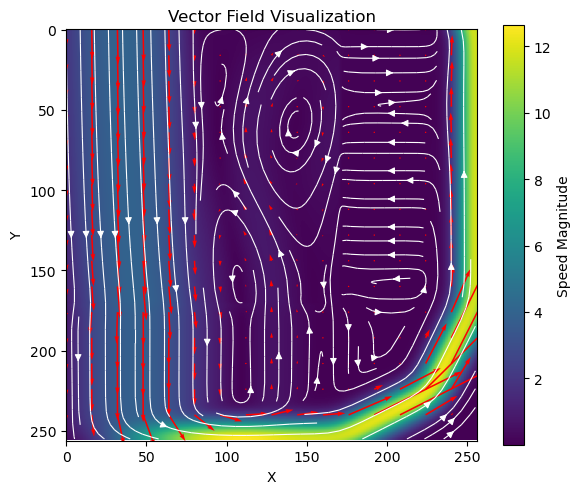

In [3]:
from flow import FlowManager

# basic test 1
flow = FlowManager(mode="data", data_path="./data/backstep_Re1000_00004.npz")

x_vals = np.linspace(0, 383, 256)
y_vals = np.linspace(0, 383, 256)
x, y = np.meshgrid(x_vals, y_vals, indexing='ij')
u, v = flow.evaluate(x+0.5, y+0.2)

plot_flow_field(u,v)

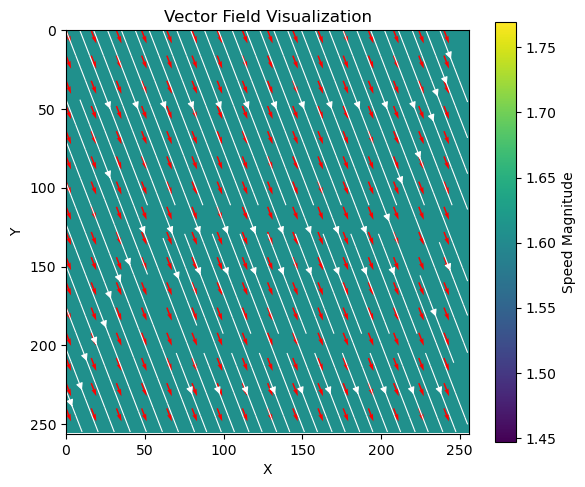

In [4]:
# basic test 2
flow = FlowManager(mode="analytical", name="uniform", uc=1.5,vc=0.58)

x_vals = np.linspace(0, 383, 256)
y_vals = np.linspace(0, 383, 256)
x, y = np.meshgrid(x_vals, y_vals,indexing='ij')
u, v = flow.evaluate(x+0.5, y+0.2)

plot_flow_field(u,v)

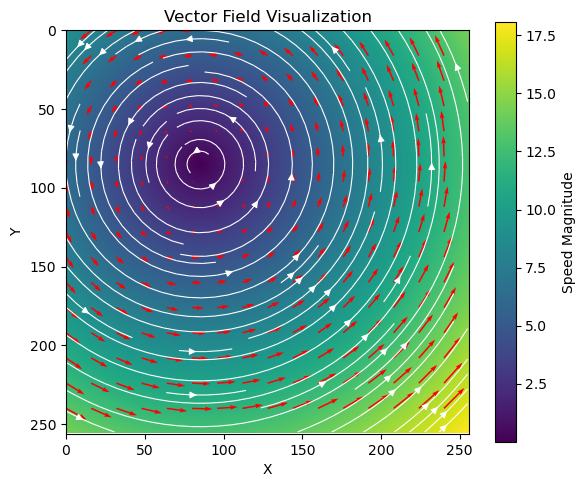

In [5]:
# basic test 3
flow = FlowManager(mode="analytical", name="solid_rot", x_c=128,y_c=128, omega=0.05)

x_vals = np.linspace(0, 383, 256)
y_vals = np.linspace(0, 383, 256)
x, y = np.meshgrid(x_vals, y_vals,indexing='ij')
u, v = flow.evaluate(x+0.5, y+0.2)

plot_flow_field(u,v)

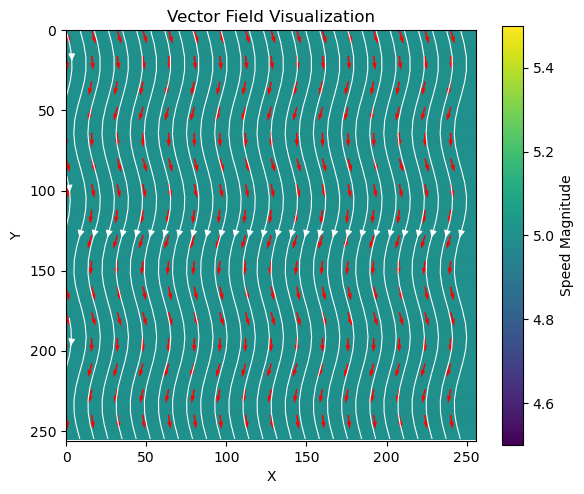

In [6]:
# basic test 4
flow = FlowManager(mode="analytical", name="sin_flow", x_c=128,y_c=128, a=6, b=128, scale=5)

x_vals = np.linspace(0, 383, 256)
y_vals = np.linspace(0, 383, 256)
x, y = np.meshgrid(x_vals, y_vals,indexing="ij")
u, v = flow.evaluate(x+0.5, y+0.2)

plot_flow_field(u,v)

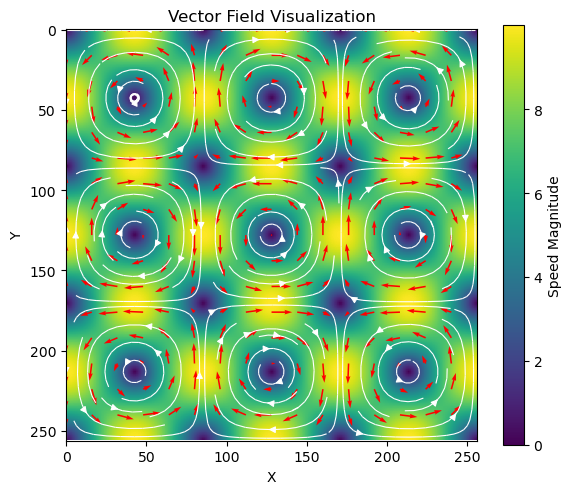

In [7]:
# basic test 5
flow = FlowManager(mode="analytical", name="cellular_flow", vmax=10, p=256)

x_vals = np.linspace(0, 383, 256)
y_vals = np.linspace(0, 383, 256)
x, y = np.meshgrid(x_vals, y_vals,indexing='ij')
u, v = flow.evaluate(x+0.0, y+0.0)

plot_flow_field(u,v)